In [51]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

**PRELIMINARY CLEANING**

In [52]:
loan_data = pd.read_csv('train_indessa.csv')

In [53]:
loan_data

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,...,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,...,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,...,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,...,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532423,31296187,20000,20000,20000.0,36 months,,12.49,B,B5,Registered Nurse,...,0.0,NaN,INDIVIDUAL,NaN,65th week,0.0,0.0,83087.0,24800.0,0
532424,29403184,12000,12000,12000.0,60 months,BAT2003848,14.99,C,C5,Account Mgr,...,0.0,NaN,INDIVIDUAL,NaN,70th week,0.0,0.0,227812.0,17800.0,0
532425,7357607,18725,18725,18725.0,60 months,NaN,20.80,E,E1,Comcast cable,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,26010.0,24200.0,1
532426,23182668,21000,21000,21000.0,60 months,BAT3193689,16.29,D,D2,Resident Physician,...,0.0,NaN,INDIVIDUAL,NaN,78th week,0.0,0.0,29197.0,23300.0,0


In [54]:
#remove some columns as our group find it does not bring values
loan_data.drop(['loan_amnt', 'title','funded_amnt_inv', 'batch_enrolled', 'sub_grade', 'pymnt_plan', 'desc', 'verification_status_joint', 'last_week_pay', 'emp_title', 'emp_length', 'zip_code', 'addr_state', 'application_type', 'total_rev_hi_lim'], axis=1, inplace=True)

In [55]:
#Removing string 'months' from term and 'th week' from last_week_pay
loan_data['term'].replace(to_replace='months', value='', regex=True, inplace=True)
# loan_default['last_week_pay'].replace(to_replace='th week', value='', regex=True, inplace=True)
loan_data['verification_status'].replace(to_replace='Source Verified', value='Verified', regex=True, inplace=True)

In [56]:
# Edit term to just 36 / 64 instead of with months behind
loan_data['term'].replace(to_replace='months', value='', regex=True, inplace=True)

In [57]:
columns_to_select = ['funded_amnt', 'term', 'int_rate', 'grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt','tot_cur_bal', 'loan_status']

In [58]:
#Purpose and home_ownership - select the 'important' data only
loan_data = loan_data[(loan_data['home_ownership'].isin(['MORTGAGE','OWN','RENT', 'OTHER', 'NONE']))][columns_to_select].reset_index().drop('index', axis=1)

In [59]:
loan_data['purpose']=loan_data['purpose'].replace(['educatio0l', 'major_purchase', 'car', 'medical', 'vacation', 'wedding', 'educational'], 'personal_loan')

loan_data['purpose']=loan_data['purpose'].replace(['home_improvement', 'house', 'moving'], 'home')

loan_data['purpose']=loan_data['purpose'].replace(['renewable_energy', 'small_business'], 'other')

loan_data.purpose.value_counts()

debt_consolidation    314987
credit_card           123670
home                   36500
other                  32128
personal_loan          25140
Name: purpose, dtype: int64

In [60]:
#Label Encoding
#creating an instance of labelencoder
labelencoder = LabelEncoder()

#Assigning numerical values and storing it in another column
loan_data['grade'] = labelencoder.fit_transform(loan_data['grade'])
loan_data['verification_status'] = labelencoder.fit_transform(loan_data['verification_status'])
loan_data['initial_list_status'] = labelencoder.fit_transform(loan_data['initial_list_status'])
loan_data['home_ownership'] = labelencoder.fit_transform(loan_data['home_ownership'])
loan_data['purpose'] = labelencoder.fit_transform(loan_data['purpose'])

loan_data

,funded_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,loan_status
0,14350,36,19.19,4,3,28700.0,1,1,33.88,0.0,...,1173.84,0.0,0.0,0.0,0.0,74.0,0.0,0.0,28699.0,0
1,4800,36,10.99,1,0,65000.0,1,2,3.64,0.0,...,83.95,0.0,0.0,0.0,0.0,NaN,0.0,0.0,9974.0,0
2,10000,36,7.26,0,3,45000.0,0,1,18.42,0.0,...,56.47,0.0,0.0,0.0,0.0,NaN,0.0,65.0,38295.0,0
3,15000,36,19.72,3,4,105000.0,0,1,14.97,0.0,...,4858.62,0.0,0.0,0.0,0.0,NaN,0.0,0.0,55564.0,0
4,16000,36,10.64,1,4,52000.0,1,0,20.16,0.0,...,2296.41,0.0,0.0,0.0,0.0,NaN,0.0,0.0,47159.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532420,20000,36,12.49,1,0,75000.0,1,1,14.53,0.0,...,2595.45,0.0,0.0,0.0,0.0,NaN,0.0,0.0,83087.0,0
532421,12000,60,14.99,2,0,59000.0,0,1,22.97,0.0,...,2182.92,0.0,0.0,0.0,0.0,NaN,0.0,0.0,227812.0,0
532422,18725,60,20.80,4,4,42504.0,1,1,27.27,0.0,...,645.32,0.0,0.0,0.0,0.0,NaN,0.0,0.0,26010.0,1
532423,21000,60,16.29,3,4,50000.0,1,0,14.91,0.0,...,4619.79,0.0,0.0,0.0,0.0,NaN,0.0,0.0,29197.0,0


**Filtering for rows that did not default**

In [61]:
loan_data['loan_status'].value_counts()

0    406599
1    125826
Name: loan_status, dtype: int64

In [62]:
loan_data = loan_data[loan_data['loan_status'] == 0]

**Keeping only useful columns**

In [63]:
# Filtering the useful data only
loan_data = loan_data[['funded_amnt', 'total_rec_int', 'annual_inc', 'revol_bal', 'term', 'int_rate', 'revol_util', 'tot_cur_bal', 'dti', 'verification_status', 'purpose', 'open_acc', 'total_acc', 'inq_last_6mths', 'mths_since_last_delinq', 'initial_list_status', 'mths_since_last_major_derog', 'loan_status']]

In [64]:
# Feature Importance
# Variable: total_rec_int        Importance: 0.32
# Variable: annual_inc           Importance: 0.15
# Variable: revol_bal            Importance: 0.15
# Variable: term                 Importance: 0.07
# Variable: int_rate             Importance: 0.06
# Variable: revol_util           Importance: 0.04 
# Variable: tot_cur_bal          Importance: 0.04
# Variable: dti                  Importance: 0.03
# Variable: verification_status  Importance: 0.02
# Variable: purpose              Importance: 0.02
# Variable: open_acc             Importance: 0.02
# Variable: total_acc            Importance: 0.02 
# Variable: grade                Importance: 0.01
# Variable: inq_last_6mths       Importance: 0.01
# Variable: mths_since_last_delinq Importance: 0.01
# Variable: initial_list_status  Importance: 0.01
# Variable: mths_since_last_major_derog Importance: 0.01
# Variable: loan_status          Importance: 0.01

In [65]:
loan_data.corr()[loan_data.corr() >= 0.8]

,funded_amnt,total_rec_int,annual_inc,revol_bal,int_rate,revol_util,tot_cur_bal,dti,verification_status,purpose,open_acc,total_acc,inq_last_6mths,mths_since_last_delinq,initial_list_status,mths_since_last_major_derog,loan_status
funded_amnt,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rec_int,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_bal,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_util,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tot_cur_bal,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verification_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purpose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping Loan Status because do not make sense

In [67]:
loan_data = loan_data.drop(columns={'loan_status'})

### Filling Null Values with Median

In [68]:
fillMedian = loan_data.copy()

In [69]:
fillMedian.isnull().sum()

funded_amnt                         0
total_rec_int                       0
annual_inc                          0
revol_bal                           0
term                                0
int_rate                            0
revol_util                        188
tot_cur_bal                      8680
dti                                 0
verification_status                 0
purpose                             0
open_acc                            3
total_acc                           3
inq_last_6mths                      3
mths_since_last_delinq         202594
initial_list_status                 0
mths_since_last_major_derog    296844
dtype: int64

In [70]:
cols_Median = ['mths_since_last_delinq', 'mths_since_last_major_derog']
cols_0 = ['tot_cur_bal']

for col in cols_Median:
    print('Imputation with Median: %s' % (col))
    fillMedian[col].fillna(fillMedian[col].median(), inplace=True)
    
for col in cols_0:
    print('Imputation with Median: %s' % (col))
    fillMedian[col].fillna(0, inplace=True)


Imputation with Median: mths_since_last_delinq
Imputation with Median: mths_since_last_major_derog
Imputation with Median: tot_cur_bal


### Drop null values (low proportion)

In [71]:
fillMedian = fillMedian.dropna(axis=0)
fillMedian

,funded_amnt,total_rec_int,annual_inc,revol_bal,term,int_rate,revol_util,tot_cur_bal,dti,verification_status,purpose,open_acc,total_acc,inq_last_6mths,mths_since_last_delinq,initial_list_status,mths_since_last_major_derog
0,14350,1173.84,28700.0,22515.0,36,19.19,73.1,28699.0,33.88,1,1,14.0,28.0,1.0,50.0,0,74.0
1,4800,83.95,65000.0,7624.0,36,10.99,23.2,9974.0,3.64,1,2,6.0,13.0,1.0,30.0,1,44.0
2,10000,56.47,45000.0,10877.0,36,7.26,31.2,38295.0,18.42,0,1,5.0,19.0,0.0,30.0,1,44.0
3,15000,4858.62,105000.0,13712.0,36,19.72,55.5,55564.0,14.97,0,1,10.0,21.0,2.0,46.0,0,44.0
4,16000,2296.41,52000.0,35835.0,36,10.64,76.2,47159.0,20.16,1,0,11.0,27.0,0.0,30.0,1,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532418,13000,1916.77,55000.0,6638.0,60,12.99,24.7,11231.0,4.65,1,1,11.0,25.0,0.0,7.0,0,7.0
532420,20000,2595.45,75000.0,15775.0,36,12.49,63.6,83087.0,14.53,1,1,12.0,34.0,0.0,30.0,0,44.0
532421,12000,2182.92,59000.0,9453.0,60,14.99,53.1,227812.0,22.97,0,1,10.0,29.0,0.0,30.0,1,44.0
532423,21000,4619.79,50000.0,20902.0,60,16.29,89.7,29197.0,14.91,1,0,7.0,14.0,1.0,30.0,1,44.0


### Partitioning the dataset into train and test

In [72]:
X = fillMedian.drop(columns={'funded_amnt'})

In [73]:
y = fillMedian['funded_amnt']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [75]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(325128, 16)
(325128,)
(81283, 16)
(81283,)


In [76]:
y

0         14350
1          4800
2         10000
3         15000
4         16000
          ...  
532418    13000
532420    20000
532421    12000
532423    21000
532424    10000
Name: funded_amnt, Length: 406411, dtype: int64

### Fitting the Linear Regression Model

In [77]:
# creation of a LinearRegression object 
lm = LinearRegression()

In [78]:
# calling the fit() function of the `LinearRegression` class
# the fit() function fits (creates) the linear model
lm.fit(X_train, y_train)

LinearRegression()

In [79]:
lm.intercept_

1973.0584049812624

In [80]:
lm.coef_

array([ 1.63865053e+00,  1.90385393e-02,  4.73519779e-02,  1.72264302e+02,
       -2.09888029e+02,  1.05826294e+00,  5.52059563e-03, -1.19750707e+01,
        2.46590171e+03, -8.25813419e+02,  6.65841403e+01,  3.05466301e+01,
       -5.09306827e+02, -3.63569987e+00,  1.09043718e+03,  3.97405639e+00])

In [81]:
lm.coef_.shape

(16,)

In [82]:
pd.DataFrame(lm.coef_,X.columns, columns=['Coefficients'])

,Coefficients
total_rec_int,1.638651
annual_inc,0.019039
revol_bal,0.047352
term,172.264302
int_rate,-209.888029
revol_util,1.058263
tot_cur_bal,0.005521
dti,-11.975071
verification_status,2465.901710
purpose,-825.813419


In [83]:
round(pd.DataFrame(lm.coef_,X.columns, columns=['Coefficients']), 2)

,Coefficients
total_rec_int,1.64
annual_inc,0.02
revol_bal,0.05
term,172.26
int_rate,-209.89
revol_util,1.06
tot_cur_bal,0.01
dti,-11.98
verification_status,2465.90
purpose,-825.81


**Evaluation of the train model using statistics**

**Variables Significance - Get the p values of the t-tests to check for significance**

In [84]:
y_train.dtypes

dtype('int64')

In [85]:
X_train.dtypes

total_rec_int                  float64
annual_inc                     float64
revol_bal                      float64
term                            object
int_rate                       float64
revol_util                     float64
tot_cur_bal                    float64
dti                            float64
verification_status              int64
purpose                          int64
open_acc                       float64
total_acc                      float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
initial_list_status              int64
mths_since_last_major_derog    float64
dtype: object

In [86]:
# We will use OLS (means Ordinary Least Squares) https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

model = sm.OLS(y_train,X_train.astype(float))

In [87]:
model_results = model.fit()

In [88]:
p_values = model_results.summary2().tables[1]['P>|t|']

In [89]:
round(p_values,4)

# from this we can see that mths_since_last_delinq is more than 0.05 significance level.

total_rec_int                  0.0000
annual_inc                     0.0000
revol_bal                      0.0000
term                           0.0000
int_rate                       0.0000
revol_util                     0.0000
tot_cur_bal                    0.0000
dti                            0.0000
verification_status            0.0000
purpose                        0.0000
open_acc                       0.0000
total_acc                      0.0000
inq_last_6mths                 0.0000
mths_since_last_delinq         0.0003
initial_list_status            0.0000
mths_since_last_major_derog    0.0000
Name: P>|t|, dtype: float64

Model Significance - get the p-value from F-Statistics test to evaluate

In [90]:
p_values = model_results.summary2()
p_values

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.877       
Dependent Variable:     funded_amnt      AIC:                         6590469.0763
Date:                   2021-11-15 17:36 BIC:                         6590640.1479
No. Observations:       325128           Log-Likelihood:              -3.2952e+06 
Df Model:               16               F-statistic:                 1.451e+05   
Df Residuals:           325112           Prob (F-statistic):          0.00        
R-squared (uncentered): 0.877            Scale:                       3.7224e+07  
----------------------------------------------------------------------------------
                              Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
----------------------------------------------------------------------------------
total_rec_int                  1.6063   0.0060 265.7433 0.0000    1.5944    1.6181
annual_inc                     0.0197   0.0002 111.6514 0.0000    0.0193    0.0200
revol_bal                      0.0463   0.0005  85.9611 0.0000    0.0453    0.0474
term                         183.8892   1.0535 174.5496 0.0000  181.8244  185.9540
int_rate                    -197.6230   3.3251 -59.4335 0.0000 -204.1402 -191.1059
revol_util                     5.4334   0.4907  11.0725 0.0000    4.4716    6.3951
tot_cur_bal                    0.0055   0.0001  64.1782 0.0000    0.0053    0.0057
dti                           -7.7193   1.4197  -5.4372 0.0000  -10.5019   -4.9367
verification_status         2533.8136  24.6041 102.9832 0.0000 2485.5902 2582.0370
purpose                     -762.3203  11.6697 -65.3247 0.0000 -785.1926 -739.4480
open_acc                      76.9774   2.8813  26.7164 0.0000   71.3301   82.6246
total_acc                     34.4920   1.3104  26.3226 0.0000   31.9237   37.0602
inq_last_6mths              -499.1410  12.0574 -41.3970 0.0000 -522.7732 -475.5088
mths_since_last_delinq        -2.7979   0.7812  -3.5814 0.0003   -4.3291   -1.2667
initial_list_status         1151.8492  22.4218  51.3719 0.0000 1107.9032 1195.7952
mths_since_last_major_derog   16.6869   0.9361  17.8256 0.0000   14.8521   18.5217
----------------------------------------------------------------------------------
Omnibus:                 70477.416          Durbin-Watson:             2.004      
Prob(Omnibus):           0.000              Jarque-Bera (JB):          3213089.624
Skew:                    0.046              Prob(JB):                  0.000      
Kurtosis:                18.400             Condition No.:             503788     
==================================================================================
* The condition number is large (5e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

**Evaluating the model against Test Dataset**

In [91]:
y_pred = lm.predict(X_test)

In [92]:
y_actual = y_test.to_numpy()

In [93]:
for i in range(0,5):
    print('\nActual:   ' + str(round(y_actual[i])))
    print('Predict.: ' + str(round(y_pred[i])))
    print('Differ.:  ' + str(round(y_actual[i]-y_pred[i])))


Actual:   14600
Predict.: 14133
Differ.:  467

Actual:   8000
Predict.: 11618
Differ.:  -3618

Actual:   20000
Predict.: 14207
Differ.:  5793

Actual:   13500
Predict.: 19647
Differ.:  -6147

Actual:   7000
Predict.: 11169
Differ.:  -4169


**Visual Evaluation using Plotting --> Checking if X linearity with Y**

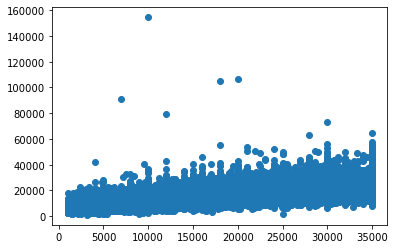

In [94]:
plt.scatter(y_test,y_pred)

**Quantitative Evaluation using RMSE and R-Squared**

In [95]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [96]:
rmse 

6093.238401874767

In [97]:
y_test.mean()

15240.545993627204

In [103]:
y_test.std()

8513.367779623424

In [99]:
r_squared = r2_score(y_test, y_pred)

In [100]:
r_squared

# Now 0.4877

0.48773003527489067

In [101]:
#Export the model
from joblib import dump,load
dump(lm,'lr.joblib')

['lr.joblib']